<a href="https://colab.research.google.com/github/sanduerhan/Licenta/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Import

In [4]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import openpyxl
from nltk.corpus import stopwords, words, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import gensim
import re, string
from string import punctuation, digits

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten ,Embedding,Input,LSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

col_list = ["Column2", "Column3"]
dataset = pd.read_excel("Training.data.xlsx", usecols=col_list)
testset = pd.read_excel("Dev.xlsx", usecols=col_list)


def add_category_id(dataset):
  dataset['category_id'] = dataset['Column3'].factorize()[0]
  category_id_dataset = dataset[['Column3', 'category_id']].drop_duplicates()

  category_to_id = dict(category_id_dataset.values)
  id_to_category = dict(category_id_dataset[['category_id', 'Column3']].values)
  return dataset,category_to_id, id_to_category

dataset, category_to_id_train, id_to_category_train = add_category_id(dataset)
testset, category_to_id_test, id_to_category_test = add_category_id(testset)
dataset = dataset.sample(frac = 1)
testset = testset.sample(frac = 1)
train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]


In [6]:
print(dataset["Column2"].head)

<bound method NDFrame.head of 6237    Thank you all : This sub is the only place whe...
6831    Do this when it gets too hard to handle : Ther...
6585    Youre all tough. : Youre all strong people, yo...
6769    Randomly Feel like dying : You can have a dece...
4241    I feel like my NYE kiss was from a dementor. :...
                              ...                        
3763    How to stop leaning on people when you are hav...
1386    to everyone, : happy new year. making my first...
7262    Don’t fucking comment : This is my note, fuck ...
441     Should I end the year with a literal fucking b...
1733    Plushcare? : Has anyone used Plushcare to get ...
Name: Column2, Length: 8068, dtype: object>


In [ ]:
train_tweets = dataset['Column2'].tolist()
test_tweets = testset['Column2'].tolist()
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['Column2'] == i ].index, inplace=True)
    return df

dataset = keep_uniques(train_tweets, dataset)
testset = keep_uniques(test_tweets, testset)

print(len(testset))

4062


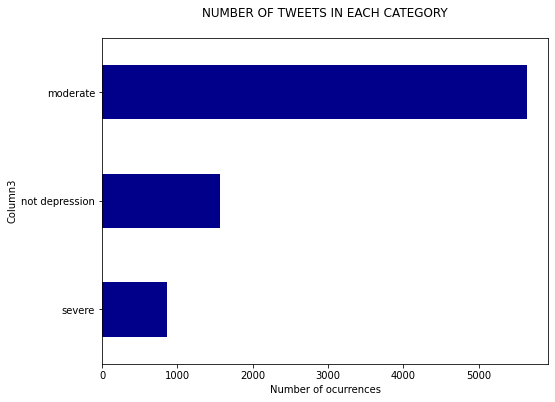

In [7]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue','darkblue']
dataset.groupby('Column3').Column2.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

# PreProcessing

In [8]:
!pip install tweet-preprocessor
import preprocessor as p

def preprocess_tweets(text):
  return p.clean(text)

print(preprocess_tweets(train_x[0]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Waiting for my mind to have a breakdown once the New Year feeling isnt there anymore : I dont know about anyone else, but Im a little bit worried that Ill go back to being depressed in a few days time or something. Last year, I tried not to have any breakdowns for the start of . A mere days later, I broke down crying. I wasnt the same for that entire year. Up until December, where I was ok that month. Now I just wait... its a weird way to act and feel, but it feels a bit normal.


In [ ]:
# cleaning the text : deleting the emojis, the existing emails, the punctuation, the present digits,
# the hyperlinks and the stopwords (a,the,is, etc)

def delete_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)  # no emoji


def delete_digits(text):
    text = text.lower()
    clean = text.translate(str.maketrans('', '', digits))
    return clean


def delete_punctuation(text):
    clean = text.translate(str.maketrans('', '', punctuation + '’“”'))
    return clean


stop = set(stopwords.words('english'))
stop.add('gtpoplt')
stop.add('new')
stop.add('year')
stop.add('eve')
stop.add('years')
stop.add('ti')
stop.add('ame')
stop.add('folks')
punct = list(string.punctuation)
stop.update(punct)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def remove_hyperlinks(text):
    for word in text:
        if re.match(r'^http', word):
            text.remove(word)
    return " ".join(text)

def remove_emails(text):
    text = text.split()
    for i in text:
        if '@' in i.strip().lower():
            text.remove(i)
    return " ".join(text)

contraction_dict = {"youre":"you are","im": "i am","wouldnt": "would not","itll": "it will","wasnt": "was not","dont": "do not","ill": "i will","isnt": "is not","cant": "cannot","arent": "are not","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# def denoise_text(text):
#     text = replace_contractions(text)
#     text = remove_words(text)
#     text = remove_emails(text)
#     text = delete_punctuation(text)
#     text = delete_emoji(text)
#     text = delete_digits(text)
#     text = remove_stopwords(text)
#     text = text.split()
#     text = remove_hyperlinks(text)
#     return text



train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]

for i in range(len(train_x)):
  train_x[i] = replace_contractions(train_x[i])
  train_x[i] = remove_emails(train_x[i])
  train_x[i] = delete_punctuation(train_x[i])
  train_x[i] = delete_emoji(train_x[i])
  train_x[i] = delete_digits(train_x[i])
  train_x[i] = remove_stopwords(train_x[i])

for i in range(len(test_x)):
  test_x[i] = replace_contractions(test_x[i])
  test_x[i] = remove_emails(test_x[i])
  test_x[i] = delete_punctuation(test_x[i])
  test_x[i] = delete_emoji(test_x[i])
  test_x[i] = delete_digits(test_x[i])
  test_x[i] = remove_stopwords(test_x[i])



In [ ]:
print(train_x[0])

waiting mind breakdown feeling anymore know anyone else little bit worried go back depressed days something last tried breakdowns start mere days later broke crying entire december ok month wait weird way act feel feels bit normal


# Lemmatization

In [11]:
# lemmatization : crying -> cry, days -> day

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemm(text):
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    sar_list_lemmatizer = [lemmatizer.lemmatize(word, get_pos(word)) for word in text]
    return " ".join(sar_list_lemmatizer)

train_x = train_x.apply(lemm)
test_x = test_x.apply(lemm)

In [ ]:
print(train_x[0])

In [ ]:
plt.figure(figsize=(12,6))
text = ' '.join(train_x[dataset['Column3']=='severe'])
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

# Count Vectorizer

In [125]:
# CountVectorizer reprezentation for the user tweets
vectorizer = CountVectorizer()
x_train_cv = vectorizer.fit_transform(train_x)

x_test_cv = vectorizer.transform(test_x)
print(x_train_cv.shape)

(8068, 10252)


# Data imbalance handling

In [126]:
sm = SMOTE(random_state = 42)
res_x, res_y = sm.fit_resample(x_train_cv, train_y)
print("After OverSampling, counts of label '2': {}".format(sum(res_y == 2)))

After OverSampling, counts of label '2': 5647


In [ ]:
os = RandomOverSampler()
res_x2, res_y2 = os.fit_resample(x_train_cv, train_y)

# Tf-Idf 

In [127]:
# Tf-idf reprezentation for the tweets
from sklearn.feature_selection import chi2
vectorizer = TfidfVectorizer(max_df = 0.15,min_df = 5, ngram_range=(1,2), stop_words='english')
train_x_tf = vectorizer.fit_transform(train_x)
test_x_tf = vectorizer.transform(test_x)
N = 2
# for Product, category_id in sorted(category_to_id_train.items()):
#     features_chi2 = chi2(train_x_tf, train_y == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(vectorizer.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Product))
#     print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
res_tfx, res_tfy = sm.fit_resample(train_x_tf, train_y)
print(train_x_tf.shape)
print(res_tfx.shape)

(8068, 33909)
(16941, 33909)


# Word2Vec

In [ ]:
sent = [row.split() for row in train_x]

In [13]:
from gensim.models.phrases import Phrases, Phraser


In [ ]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
print(sentences)

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     )

In [ ]:
w2v_model.build_vocab(sentences)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(5675934, 16754460)

In [ ]:
w2v_model.wv.most_similar(positive=["depression"])

[('anxiety', 0.5718693733215332),
 ('diagnose', 0.5230121612548828),
 ('disorder', 0.4272606372833252),
 ('ptsd', 0.3910037577152252),
 ('severe', 0.3898566663265228),
 ('adhd', 0.37263554334640503),
 ('recently', 0.37178850173950195),
 ('symptom', 0.3715326488018036),
 ('battling', 0.3693320155143738),
 ('struggle', 0.35999664664268494)]

In [56]:
def word2(train_x):
  mes = []
  for i in train_x:
    mes.append(i.split())
  word2vec_model = Word2Vec(mes, size=300, window=5, min_count=1)
  token = Tokenizer()
  token.fit_on_texts(mes)
  text = token.texts_to_sequences(mes)
  text = pad_sequences(text, 1464)
  word_index = token.word_index
  return word2vec_model,word_index,text

In [57]:
model,word_index,pad_rev_train = word2(train_x)

In [58]:
model2,word_index2,pad_rev_test = word2(test_x)

In [60]:
model2.wv.most_similar("sex")

[('available', 0.9989280700683594),
 ('circle', 0.9982731342315674),
 ('confess', 0.9981011152267456),
 ('woman', 0.9979820847511292),
 ('business', 0.9978442192077637),
 ('host', 0.9977796673774719),
 ('bond', 0.997644305229187),
 ('contact', 0.9974455237388611),
 ('argue', 0.997405469417572),
 ('manipulate', 0.9973846673965454)]

In [31]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [61]:
embedding_vectors = get_weight_matrix(model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [80]:
def w2v_embedding(train_text):
  ## create list of lists of unigrams
  lst_corpus = []
  for string in train_text:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

  ## detect bigrams and trigrams
  bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                  delimiter=" ".encode(), min_count=30)
  bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
  trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
              delimiter=" ".encode(), min_count=30)
  trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

  nlp = Word2Vec(lst_corpus, size=300,   
            window=8, min_count=2, sg=1, iter=30)
  return nlp, lst_corpus, bigrams_detector, trigrams_detector

In [81]:
def feature_engineering(lst_corpus, train_text):
  tokenizer = Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(lst_corpus)
  dic_vocabulary = tokenizer.word_index
  ## create sequence
  lst_corpus = []
  for string in train_text:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
  lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
  ## padding sequence
  X_train = pad_sequences(lst_text2seq, 
                      maxlen=30, padding="post", truncating="post")
  return tokenizer, dic_vocabulary, X_train

In [82]:
def make_embedding_matrix(dic_vocabulary, nlp):
  ## start the matrix (length of vocabulary x vector size) with all 0s
  embeddings = np.zeros((len(dic_vocabulary)+1, 300))
  for word,idx in dic_vocabulary.items():
      ## update the row with vector
      try:
          embeddings[idx] =  nlp[word]
      ## if word not in model then skip and the row stays all 0s
      except:
          pass
  return embeddings

In [83]:
nlp, lst_corpus, bigrams_detector, trigrams_detector = w2v_embedding(train_x)

In [84]:
print(nlp.wv.most_similar(positive="depression"))

[('stabilizer', 0.3611605167388916), ('microdosing', 0.34207403659820557), ('anxiety', 0.3333049416542053), ('diagnose', 0.3303808569908142), ('phobia', 0.32765257358551025), ('mercury', 0.325138658285141), ('feverbaby', 0.3229295313358307), ('um', 0.32083916664123535), ('sought', 0.3179461359977722), ('intuniv', 0.3177012801170349)]


In [85]:
tokenizer, dic_vocabulary, X_train = feature_engineering(lst_corpus,train_x)

In [107]:
print(X_train.shape)

(8068, 30)


In [86]:
embeddings_train = make_embedding_matrix(dic_vocabulary, nlp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [99]:
def test_handling(test_text,bigrams_detector, trigrams_detector, tokenizer):
  ## create list of n-grams
  lst_corpus = []
  for string in test_text:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                  len(lst_words), 1)]
      lst_corpus.append(lst_grams)
      
  ## detect common bigrams and trigrams using the fitted detectors
  lst_corpus = list(bigrams_detector[lst_corpus])
  lst_corpus = list(trigrams_detector[lst_corpus])
  ## text to sequence with the fitted tokenizer
  lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

  ## padding sequence
  X_test = pad_sequences(lst_text2seq, maxlen=30,
              padding="post", truncating="post")
  return X_test

In [112]:
nlp2, lst_corpus2, bigrams_detector2, trigrams_detector2 = w2v_embedding(test_x)

In [113]:
x_test = test_handling(test_x, bigrams_detector2, trigrams_detector2, tokenizer)

In [114]:
print(x_test.shape)

(4078, 30)


# Naive Bayes

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_x, res_y)
pred_y = naive_bayes_classifier.predict(x_test_cv)

score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y, digits = 4))

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_tfx, res_tfy)
# naive_bayes_classifier.fit(train_x_tf, train_y)
pred_y = naive_bayes_classifier.predict(test_x_tf)
score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y, digits = 4))

# AdaBoost

In [ ]:
# res_x2, res_y2 = sm.fit_resample(train_x_tf, train_y)
ada = AdaBoostClassifier()

# boost = ada.fit(train_x_tf, train_y)
boost = ada.fit(res_tfx, res_tfy)
pred_y = boost.predict(test_x_tf)
print("AdaBoost Classifier Model Accuracy:", accuracy_score(test_y, pred_y))
print(metrics.classification_report(test_y, pred_y))

# Regression

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 4.}

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3)
model = model.fit(res_x, res_y)
y_pred = model.predict(x_test_cv)

# model = model.fit(res_tfx, res_tfy)
# y_pred = model.predict(test_x_tf)

print("Regression Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred, digits = 4))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


In [ ]:

class_weight = {0: 1.,
                1: 3.,
                2: 6.}
model = LinearSVC()
# model = model.fit(train_x_tf, train_y)
# y_pred = model.predict(test_x_tf)
model = model.fit(res_x, res_y)
y_pred = model.predict(x_test_cv)
print("Svc Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred, digits = 4))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


In [ ]:

class_weight = {0: 1.,
                1: 3.,
                2: 5.}
model = RandomForestClassifier(class_weight=class_weight)
model = model.fit(train_x_tf,train_y)
y_pred = model.predict(test_x_tf)
print("RandomForest Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)

# F1 metric

In [33]:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Neural Network

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 5.}
# def split(pad_rev,train_y):
#   Y=keras.utils.to_categorical(train_y)  # one hot target as required by NN.
#   x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.05,random_state=42)
#   return x_train, x_test,y_train,y_test
def network(embeddings):
 ## input
  x_in = layers.Input(shape=(30,))
  ## embedding
  x = layers.Embedding(input_dim=embeddings.shape[0],  
                      output_dim=embeddings.shape[1], 
                      weights=[embeddings],
                      input_length=30, trainable=False)(x_in)
  ## 2 layers of bidirectional lstm
  x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2, 
                          return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2))(x)
  ## final dense layers
  x = layers.Dense(64, activation='elu')(x)
  y_out = layers.Dense(3, activation='softmax')(x)
  ## compile
  model = Model(x_in, y_out)
  model.compile(loss=f1_loss,
                optimizer='adam', metrics=[f1])
  return model
Y=keras.utils.to_categorical(train_y)
Y2=keras.utils.to_categorical(test_y)
# x_train,x_test,y_train,y_test = split(X_train,train_y)
model = network(embeddings_train)
# x_valid, x_x, y_valid, y_y = split(x_test,test_y)
model.fit(X_train, Y, epochs=10, batch_size=64, validation_data=(x_test,Y2))


In [ ]:
pred_y = model.predict(x_test)
pred_y = np.argmax(pred_y, axis=1)
# y_test=np.argmax(y_test, axis=1)
print(metrics.classification_report(test_y, pred_y, digits = 4))

conf_mat = confusion_matrix(test_y, pred_y)
print(conf_mat)

# BERT

In [ ]:
!pip install transformers

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

In [145]:
from keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

In [17]:
def sentence(texts):
  model = SentenceTransformer("roberta-large-nli-stsb-mean-tokens")
  embeddings = model.encode(texts)

  return embeddings

In [147]:
TRANSFORMER_BATCH=128

def count_embedd (df):
    idx_chunk=list(df.columns).index('Column2')
    embedd_lst = []
    for index in range (0, len(df), TRANSFORMER_BATCH):
        embedds = model.encode(df.iloc[index:index+TRANSFORMER_BATCH, idx_chunk].values, show_progress_bar=False)
        embedd_lst.append(embedds)
    return np.concatenate(embedd_lst)

In [148]:
train_emb = count_embedd(dataset)

In [149]:
test_emb = count_embedd(testset)

In [150]:
X_train = np.array(train_emb)
X_test = np.array(test_emb)

In [151]:
y_train=keras.utils.to_categorical(train_y)

In [ ]:
KERAS_VALIDATION_SPLIT=0.00
KERAS_EPOCHS=10
KERAS_BATCH_SIZE=16

class_weight = {0: 1.,
                1: 3.,
                2: 6.}

# Create and train Keras model
n_features=X_train.shape[1]
n_labels = y_train.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2048, input_dim=n_features),
  tf.keras.layers.LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64),
  tf.keras.layers.LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

LR=5e-4
adam = keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam, 
              loss="categorical_crossentropy",
              metrics=[f1])

model.fit(X_train, y_train, epochs=KERAS_EPOCHS, batch_size=KERAS_BATCH_SIZE, validation_split=KERAS_VALIDATION_SPLIT)

In [ ]:
y_preds = model.predict(X_test)
predicted = np.argmax(y_preds,axis=1) 
accuracy = metrics.accuracy_score(test_y, predicted)
print("Accuracy:",  round(accuracy,4))
print(metrics.classification_report(test_y, predicted,digits=4))

conf_mat = confusion_matrix(test_y, predicted)
print(conf_mat)